<a href="https://colab.research.google.com/github/tortas/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/DS_Unit_2_Sprint_Challenge_4_Practicing_Understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science Unit 2_
 
 # Sprint Challenge: Practicing & Understanding Predictive Modeling

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) **Use cross-validation** to **do hyperparameter optimization**, and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

### Part 4: Gradient Descent

Answer both of these two questions:

- What does Gradient Descent seek to minimize?
- What is the "Learning Rate" and what is its function?

One sentence is sufficient for each.

_To earn a score of 3 for this part, go above and beyond. Show depth of understanding and mastery of intuition in your answers._

## **Part 1**

In [0]:
train = train.dropna()

In [0]:
X_train = train[['Facility Type', 'Risk', 'Inspection Type', 'Violations']]

In [23]:
X_train.shape

(41665, 4)

In [0]:
y_train = train['Fail']

In [22]:
y_train.shape

(41665,)

In [24]:
!pip install category_encoders

     |████████████████████████████████| 92kB 3.4MB/s 


In [0]:
import category_encoders as ce

In [0]:
encoder = ce.BinaryEncoder()
X_train = encoder.fit_transform(X_train)

In [27]:
X_train.head()

,Facility Type_0,Facility Type_1,Facility Type_2,Facility Type_3,Facility Type_4,Facility Type_5,Facility Type_6,Facility Type_7,Facility Type_8,Facility Type_9,Risk_0,Risk_1,Risk_2,Inspection Type_0,Inspection Type_1,Inspection Type_2,Inspection Type_3,Inspection Type_4,Inspection Type_5,Violations_0,Violations_1,Violations_2,Violations_3,Violations_4,Violations_5,Violations_6,Violations_7,Violations_8,Violations_9,Violations_10,Violations_11,Violations_12,Violations_13,Violations_14,Violations_15,Violations_16
0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


## **Part 2**

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

param_distributions = {
    'n_estimators': [100, 200], 
    'max_depth': [4, 5]
}

gridsearch = RandomizedSearchCV(
    RandomForestClassifier(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=8, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 4 is smaller than n_iter=8. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   19.8s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=8, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200], 'max_depth': [4, 5]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [0]:
best = gridsearch.best_estimator_

In [36]:
best.predict_proba(X_train)

array([[0.7296855 , 0.2703145 ],
       [0.73973799, 0.26026201],
       [0.82860286, 0.17139714],
       ...,
       [0.68956112, 0.31043888],
       [0.81253316, 0.18746684],
       [0.72860636, 0.27139364]])

In [0]:
from sklearn.model_selection import cross_val_predict

y_pred_proba = cross_val_predict(best, X_train, y_train, cv=3, n_jobs=-1, 
                                 method='predict_proba')[:,1]

In [0]:
from sklearn.metrics import roc_auc_score

In [40]:
roc_auc_score(y_train, y_pred_proba)

0.6468144552158841

## **Part 3**

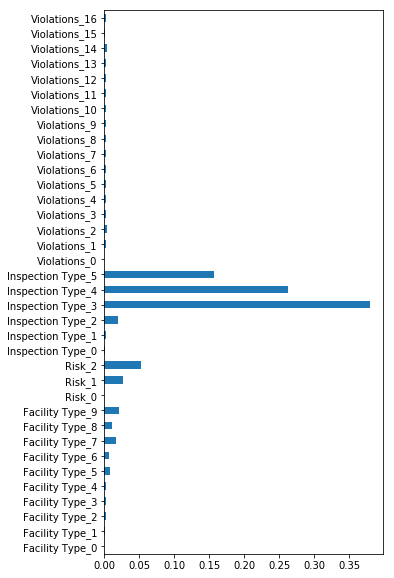

In [43]:
import matplotlib.pyplot as plt

figsize = (5,10)

importances = pd.Series(best.feature_importances_, X_train.columns)
plt.figure(figsize=figsize)
importances.plot.barh()

## **Part 4**



1.   Gradient descent seeks to minimize a "cost" function which is basically something that tells the computer how well its performing. The overall process of gradient descent consists of calculating the direction of quickest descent and nudging an input along it then repeating the process from the new starting point.
2.   The learning rate is the scaler which dictates how far the step is in the direction of the negative gradient. Multiplying the learning rate by the negative gradient and applying it to our starting point gives us our end point.

